#### Nonlinearity

In the previous notebook, we have seen a few techniques that can be used to numerically evaluate the `uncertainty of a linear model`, and obtain the uncertainty associated with the `prediction` on testing data points

The natural question becomes, what if we want to fit a nonlinear model to data, for example, like the data generated as follows

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

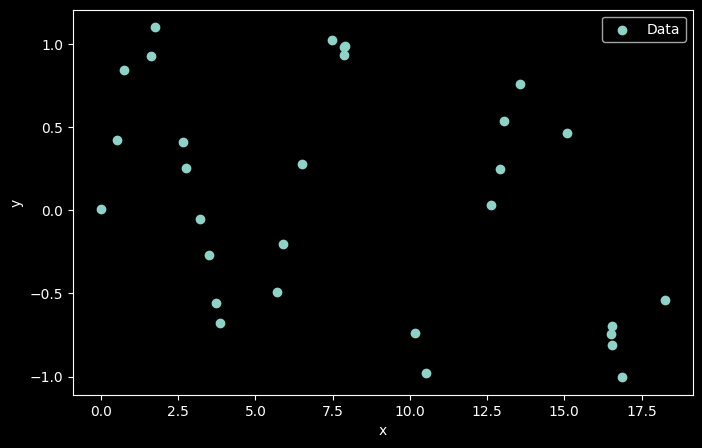

In [13]:
# Generate data
np.random.seed(1)

num_points = 30

x = np.random.uniform(0, 6 * np.pi, num_points)

# True standard deviation of noise in measured y, only used in generating data
sigma_d_true = 0.1

# Guessed standard deviation of noise in measured y, only used in model
sigma_d = 0.1

# Guessed standard deviation of prior on weights, only used in model
sigma_theta = 0.5

# Kernel parameters
sigma_k = 0.9

y = np.sin(x) + np.random.normal(0, sigma_d_true, size=x.shape)

fig_0, ax_0 = plt.subplots(figsize=(8, 5))
ax_0.scatter(x, y, label='Data')
ax_0.set_xlabel('x')
ax_0.set_ylabel('y')
ax_0.legend()
plt.show()

So far, the tools that we have explored to tackle nonlinearity include projection into `feature space` and `kernel`

#### Projection into `feature space`

One of the projections is for example

$$\mathbf{\phi}(x)=\begin{bmatrix} x^2 \\ x \\ 1 \end{bmatrix}$$

corresponding to a transformation

$$\mathbf{\phi}(x)=\begin{bmatrix} \phi_1(x) \\ \phi_2(x) \\ \phi_3(x) \end{bmatrix}$$

where

$$\begin{align*}
\phi_1(x)&=x^2 \\
\phi_2(x)&=x \\
\phi_3(x)&=1
\end{align*}$$

We see that $\phi_1(x)$ at least allows $x$ to vary `quadratically` with $y$, rather than just linearly...

#### `Kernel` method

We have also seen that a much better method to account for nonlinearity, espeically local nonlinear pattern is through kernel function (notably RBF kernel), based on `correlation` between point $x$ and anchor point $x_i$

$$k(x, x_i)=e^{-\frac{(x-x_i)^2}{2\sigma_k^2}}$$

We have seen that the following RBF kernel outputs can be directly used as a `feature vector` $\phi(x)$ to represent $x$

$$\phi(x)=\begin{bmatrix} e^{-\frac{(x-x_1)^2}{2\sigma_k^2}} \\ e^{-\frac{(x-x_2)^2}{2\sigma_k^2}}\\ ...\\ e^{-\frac{(x-x_m)^2}{2\sigma_k^2}} \end{bmatrix}$$

leading to

$$y=\phi(x)^T\cdot\theta$$

and its performance of predicting $y$ is excellent (as shown in 1d and 2d classification problems)

In [14]:
# Define RBF kernel function
def rbf_kernel(x_set_1, x_set_2, sigma_k):
    if np.ndim(x_set_2) == 1:
        x_set_2 = x_set_2.reshape(-1, 1)
    if np.ndim(x_set_1) == 1:
        x_set_1 = x_set_1.reshape(-1, 1)
    num_rows = x_set_1.shape[0]
    num_cols = x_set_2.shape[0]
    k_mat = np.zeros((num_rows, num_cols))
    for i in range(num_rows):
        for j in range(num_cols):
            sq_dist = np.sum((x_set_1[i,:] - x_set_2[j,:])**2)
            k_mat[i, j] = np.exp(-sq_dist / (2 * sigma_k**2))
    return k_mat

#### So, what else do we need for uncertainty quantification?

We can just `replace` $x$ with this $\phi(x)$ wherever $x$ appears in previous computation of `linear model`, correct?

Sadly, not that straightforward

The reason is that, to deal with uncertainty, we need a way to `preserve` correlation between $x, x_i$, regardless whether they are in original space or in feature space $\phi(x), \phi(x_i)$, that is

$$\boxed{\phi(x)^T\cdot \phi(x_i)=k(x, x_i)=e^{-\frac{(x-x_i)^2}{2\sigma_k^2}}}$$

If we plug in $\phi(x)$ defined using RBF kernel as follows

$$\phi(x)=\begin{bmatrix} e^{-\frac{(x-x_1)^2}{2\sigma_k^2}} \\ e^{-\frac{(x-x_2)^2}{2\sigma_k^2}}\\ ...\\ e^{-\frac{(x-x_m)^2}{2\sigma_k^2}} \end{bmatrix}$$

we see that this equation `does not hold`

So what do we do to get $\phi(x)$ that can preserve correlation?

#### Virtual samples through `eigendecomposition`

Assume we have $m$ (training) data points: $x_1, x_2, ..., x_m$

We know how to compute the correlation between each pair, it gives us a matrix $X_k$ where the `ith row` and the `jth column` is

$$e^{-\frac{(x_i-x_j)^2}{2\sigma_k^2}}$$

Now, assume we can write out all transformed $x_i$ ($i=1, 2,..., m$) as

$$F=\begin{bmatrix} ---\phi(x_1)^T--- \\ ---\phi(x_2)^T--- \\ ... \\ ---\phi(x_m)^T--- \end{bmatrix}$$

This matrix has $m$ rows and each row corresponds to a `(transposed) transformation` of $x$: $\phi(x)^T$

As a result, $F$ and its transpose $F^T$ must satisfy the condition of preservation of correlation

It is not very difficult to see that the following must hold

$$F\cdot F^T =\begin{bmatrix} ---\phi(x_1)^T--- \\ ---\phi(x_2)^T--- \\ ... \\ ---\phi(x_m)^T--- \end{bmatrix}\begin{bmatrix} | & | & ... & | \\ | & | & ... & | \\ \phi(x_1)& \phi(x_2) & ... & \phi(x_m) \\ | & | & ... & | \\ | & | & ... & | \end{bmatrix} = X_k$$

Because $X_k$ is symmetric, it has a nice property that allows us to decompose  $X_k$ as (known as `eigendecomposition`)

$$X_k = U\Lambda U^T$$

where the `ith column` in $U$ contains the `ith eigenvector` of $X_k$ and $\Lambda$ contains corresponding `eigenvalues` of $X_k$ in its diagonal and 0 off-diagonal.

As $\Lambda$ is symmetric, we can write

$$X_k = U\Lambda^{\frac{1}{2}} \Lambda^{\frac{1}{2}}U^T=U\Lambda^{\frac{1}{2}} (\Lambda^{\frac{1}{2}})^T U^T = U\Lambda^{\frac{1}{2}} (U\Lambda^{\frac{1}{2}} )^T$$

Here, we used the property that `symmetric matrix` $\Lambda$ equals its transpose

and transpose of matrix multiplication `inverts the order` of multiplication after transpose. For example if B and C are two matrices, then

$$(BC)^T=C^TB^T$$

As a result, we have

$$F=\begin{bmatrix} ---\phi(x_1)^T--- \\ ---\phi(x_2)^T--- \\ ... \\ ---\phi(x_m)^T--- \end{bmatrix} = U\Lambda^{\frac{1}{2}}=\begin{bmatrix} | & | & ... & | \\ | & | & ... & | \\ \mathbf{u}_1& \mathbf{u}_2 & ... & \mathbf{u}_m \\ | & | & ... & | \\ | & | & ... & | \end{bmatrix}\begin{bmatrix} \lambda_1^{\frac{1}{2}} & 0 & ... & 0 \\ 0 & \lambda_2^{\frac{1}{2}} & ... & 0 \\  &   & ... &   \\  0 & 0 & ... & \lambda_m^{\frac{1}{2}} \end{bmatrix}$$

where the ith `row` of $U\Lambda^{\frac{1}{2}}$ represents $\phi(x_i)^T$, which is of length $m$

#### Small eigenvalues and numerical `stability`

Finally, as often the last several eigenvalues can be very small, in order to avoid `numerical problem` in computation, we cut eigenvalues smaller than a threshold and their corresponding eigenvectors out of computation

Assume we have only `l` eigenvalues that are larger than a threshold, then

$$F=\begin{bmatrix} ---\phi(x_1)^T--- \\ ---\phi(x_2)^T--- \\ ... \\ ---\phi(x_m)^T--- \end{bmatrix} = U\Lambda^{\frac{1}{2}}\approx\begin{bmatrix} | & | & ... & | \\ | & | & ... & | \\ \mathbf{u}_1& \mathbf{u}_2 & ... & \mathbf{u}_l\\ | & | & ... & | \\ | & | & ... & | \end{bmatrix}\begin{bmatrix} \lambda_1^{\frac{1}{2}} & 0 & ... & 0 \\ 0 & \lambda_2^{\frac{1}{2}} & ... & 0 \\  &   & ... &   \\  0 & 0 & ... & \lambda_l^{\frac{1}{2}} \end{bmatrix}$$

#### Retain `linear form` with virtual samples

Now, the linear problem $y=ax$ becomes

$$y=\phi(x)^T \cdot \theta$$

and the length of $\phi(x)^T$ and $\theta$ equals the `remaining` number of eigenvalues $l$, and we can write

$$\begin{align*}
\phi(x)^T&=\begin{bmatrix}\phi_1(x) & \phi_2(x) & ... & \phi_l(x)\end{bmatrix} \\\theta^T&=\begin{bmatrix}\theta_1 & \theta_2 & ... & \theta_l \end{bmatrix}
\end{align*}$$

and we can call $\phi(x)^T=\begin{bmatrix}\phi_1(x) & \phi_2(x) & ... & \phi_l(x)\end{bmatrix}$ the `virtual sample` of $x$ through eigendecomposition

In [15]:
# Compute kernel matrix
x_k = rbf_kernel(x, x, sigma_k)
print(f'x_k: {x_k.shape}\n{x_k[:5,:5]}')

# Eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(x_k)

print(f'eigenvalues: {eigenvalues.shape}')
print(f'eigenvectors: {eigenvectors.shape}')

# Virtual samples for training
threshold = 1e-10
mask = eigenvalues > threshold
eigenvalues = eigenvalues[mask]
eigenvectors = eigenvectors[:, mask]
print(f'eigenvalues after thresholding (if needed): {eigenvalues.shape}')
print(f'eigenvectors after thresholding (if needed): {eigenvectors.shape}')
v_samples_train = eigenvectors @ np.diag(np.sqrt(eigenvalues))

print(f'v_samples_train @ v_samples_train.T: \n{(v_samples_train @ v_samples_train.T)[:5,:5]}')
print(f'virtual samples shape: {v_samples_train.shape}')
print(v_samples_train[:5,:5])

x_k: (30, 30)
[[ 1.00e+00  1.73e-09  2.78e-17  5.59e-02  1.10e-07]
 [ 1.73e-09  1.00e+00  3.92e-50  2.28e-17  4.61e-32]
 [ 2.78e-17  3.92e-50  1.00e+00  2.00e-09  8.95e-03]
 [ 5.59e-02  2.28e-17  2.00e-09  1.00e+00  4.95e-03]
 [ 1.10e-07  4.61e-32  8.95e-03  4.95e-03  1.00e+00]]
eigenvalues: (30,)
eigenvectors: (30, 30)
eigenvalues after thresholding (if needed): (28,)
eigenvectors after thresholding (if needed): (30, 28)
v_samples_train @ v_samples_train.T: 
[[ 1.00e+00  1.73e-09  8.07e-16  5.59e-02  1.10e-07]
 [ 1.73e-09  1.00e+00 -4.19e-16 -1.78e-16 -1.65e-16]
 [ 8.07e-16 -4.19e-16  1.00e+00  2.00e-09  8.95e-03]
 [ 5.59e-02 -1.78e-16  2.00e-09  1.00e+00  4.95e-03]
 [ 1.10e-07 -1.65e-16  8.95e-03  4.95e-03  1.00e+00]]
virtual samples shape: (30, 28)
[[ 1.01e-06  4.45e-05 -8.87e-04 -2.30e-03 -9.98e-04]
 [ 4.03e-09 -1.49e-07  9.28e-05 -2.08e-05  1.62e-05]
 [ 2.22e-07  7.80e-06  1.37e-05  3.88e-05 -2.55e-04]
 [-9.13e-07  2.36e-05 -1.08e-04 -2.89e-04  1.94e-04]
 [ 9.48e-05  6.77e-04  1.4

We see that the correlation matrix obtained directly using kernel function $X_k$ and the one obtained using dot product between virtual samples $\phi(x)^T\phi(x)$ are very close, indicating good preservation of correlation among training data points

#### Gradient descent to find $\theta_{MAP}$ (or $\theta_{ML}$)

In [16]:
# Learning rate and iterations for gradient descent
learning_rate = 0.00001
iterations = 10000

# Initial guess for weights
theta = np.zeros(v_samples_train.shape[1])

In [17]:
# Gradient descent to find MAP estimate
for k in range(iterations):
    y_pred = v_samples_train @ theta
    prior_theta = np.mean(theta**2) / sigma_theta**2
    likelihood = np.mean((y_pred - y)**2) / sigma_d**2
    loss = prior_theta + likelihood

    grad_prior_theta = theta / sigma_theta**2
    grad_likelihood = v_samples_train.T @ (y_pred - y) / sigma_d**2
    grad_loss = grad_prior_theta + grad_likelihood

    theta -= learning_rate * grad_loss

    if k % (iterations // 10) == 0:
        print(f"Iteration {k}: loss = {loss:.4f}")

theta_map = theta # this theta_ml if theta is uniformly distributed
print(f"MAP estimate of parameters: {theta_map}")

Iteration 0: loss = 46.2891
Iteration 1000: loss = 2.1549
Iteration 2000: loss = 1.4602
Iteration 3000: loss = 1.3296
Iteration 4000: loss = 1.2736
Iteration 5000: loss = 1.2423
Iteration 6000: loss = 1.2229
Iteration 7000: loss = 1.2101
Iteration 8000: loss = 1.2011
Iteration 9000: loss = 1.1947
MAP estimate of parameters: [ 4.45e-05  6.06e-05 -5.63e-04  3.55e-03 -9.31e-03  7.60e-03  2.29e-02
 -2.54e-02 -4.28e-02 -5.42e-02 -1.63e-01  5.32e-02  2.11e-01 -2.72e-01
  4.40e-01 -3.82e-01 -4.57e-01  5.71e-02  2.97e-01  7.72e-01 -7.48e-01
 -9.70e-01  6.04e-01 -9.35e-01 -4.65e-01 -7.51e-01  8.12e-01 -1.35e-01]


#### Transformation of `testing data` into virtual samples



Now we have obtained $\theta_{MAP}$ using gradient descent, we can test it on our $x_{test}$

But remember, $\theta$ is only valid for transformed $\phi(x_{test})$

Assume we have a set of `test` $x$: $x_{t,1}, x_{t,2}, ..., x_{t,N}$, and we put all $\phi(x_{t,i})$ in to a `matrix` $M$

Apparently, the correlation between $x_{t,i}$ and $x_j$ must be preserved by $\phi(x_{t,i})^T\cdot \phi(x_j)$

So, the following must hold

$$M\cdot F^T=\begin{bmatrix} ---\phi(x_{t,1})^T--- \\ ---\phi(x_{t,2})^T--- \\ ... \\ ---\phi(x_{t,N})^T--- \end{bmatrix}\begin{bmatrix} | & | & ... & | \\ | & | & ... & | \\ \phi(x_1)& \phi(x_2) & ... & \phi(x_m) \\ | & | & ... & | \\ | & | & ... & | \end{bmatrix}=X_{t,k}$$

Here, $M$ is $N\times m$, $F^T$ is $m \times m$, and $X_{t,k}$ is $N \times m$, where its entry at `ith row` and `jth column` is computed as

$$e^{-\frac{(x_{t,i}-x_j)^2}{2\sigma_k^2}}$$

As we know $F^T=(U\Lambda^{\frac{1}{2}})^T=\Lambda^{\frac{1}{2}}U^T$, and we can compute $X_{t,k}$, therefore, matrix $M$ can be obtained as

$$M=X_{t,k}(F^T)^{-1}=X_{t,k}(\Lambda^{\frac{1}{2}}U^T)^{-1}=X_{t,k}U(\Lambda^{-\frac{1}{2}})$$

Here, we used property

$$(BC)^{-1}=C^{-1}B^{-1}$$

and property of full eigenvector matrix $U$

$$U^T=U^{-1}$$

When computing $X_{t,k}U(\Lambda^{-\frac{1}{2}})$, we only use reduced $U$ and $\Lambda$ if smaller eigenvalues are removed

The `ith row` in $M$ represents $\phi(x_{t,i})^T=\begin{bmatrix}\phi_1(x_{t,i}) & \phi_2(x_{t,i}) & ... & \phi_l(x_{t,i})\end{bmatrix}$, which is virtual sample corresponding to $x_{t, i}$

#### Prediction for testing data

Now, we can make prediction for any testing data (not yet with uncertainty)

v_samples_test shape: (200, 28)
[[ 4.80e-03  1.55e-89  3.38e-98  1.26e-74  1.46e-03]
 [ 3.17e-03  1.25e-90  2.41e-99  1.27e-75  9.28e-04]
 [ 2.07e-03  9.87e-92  1.70e-100  1.25e-76  5.79e-04]
 [ 1.32e-03  7.70e-93  1.17e-101  1.22e-77  3.56e-04]
 [ 8.36e-04  5.92e-94  8.00e-103  1.17e-78  2.15e-04]]
[[ 4.80e-03  8.13e-12 -1.51e-12  7.37e-11  1.46e-03]
 [ 3.17e-03  6.74e-12 -1.25e-12  6.11e-11  9.28e-04]
 [ 2.07e-03  5.48e-12 -1.02e-12  4.96e-11  5.79e-04]
 [ 1.32e-03  4.36e-12 -8.10e-13  3.95e-11  3.55e-04]
 [ 8.36e-04  3.41e-12 -6.33e-13  3.09e-11  2.15e-04]]


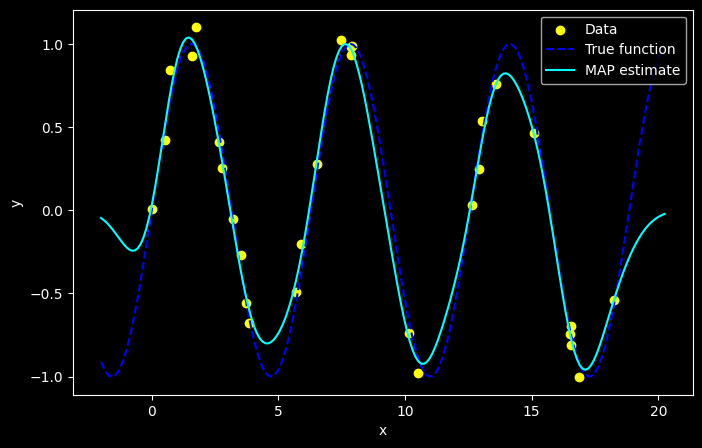

In [18]:
# Generate new data points for visualization
num_x_test = 200
x_test = np.linspace(x.min() - 2, x.max() + 2, num_x_test)
x_test_kernel = rbf_kernel(x_test, x, sigma_k)

# Virtual samples for testing
v_samples_test = x_test_kernel @ eigenvectors @ np.diag(1 / np.sqrt(eigenvalues))
print(f'v_samples_test shape: {v_samples_test.shape}')

print(x_test_kernel[-5:,-5:])
print((v_samples_test@v_samples_train.T)[-5:,-5:])

# Prediction using MAP estimator
y_test = v_samples_test @ theta_map

fig_1, ax_1 = plt.subplots(figsize=(8, 5))

ax_1.scatter(x, y, label='Data', color='yellow')
ax_1.plot(x_test, np.sin(x_test), label='True function', color='blue', linestyle='--')
ax_1.plot(x_test, y_test, label='MAP estimate', color='cyan', linestyle='-')
ax_1.set_xlabel('x')
ax_1.set_ylabel('y')
ax_1.legend()
plt.show()

#### Sampling from $p(\theta|D)$

To obtain model uncertainty, we turn to `Taylor approximation` as before in linear model to approximate $\log p(\theta|D)$ around $\theta_{MAP}$ by a `Gaussian distribution`, so that we can sample $\theta$ from it

As with previously, we take the `first three terms` of (vector type) Taylor approximation of $\log p(\theta|D)$ around $\theta_{MAP}$ (as $\theta$ is now a `vector`)

$$\log p(\theta|D)\approx \log p(\theta|D)|_{\theta=\theta_{MAP}}+(\theta-\theta_{MAP})^T\left.\frac{d}{d\theta}\log p(\theta|D)\right|_{\theta=\theta_{MAP}}+\left.\frac{1}{2}(\theta-\theta_{MAP})^T\frac{d^2}{d\theta^2}\log p(\theta|D)\right|_{\theta=\theta_{MAP}}(\theta-\theta_{MAP})$$

As $\theta_{MAP}$ is a maximum of $\log p(\theta|D)$, therefore, the first derivative is zero and we are left with

$$\log p(\theta|D)\approx \log p(\theta_{MAP}|D)-\left.\frac{1}{2}(\theta-\theta_{MAP})^T\frac{d^2}{d\theta^2}\left(-\log p(\theta|D)\right)\right|_{\theta=\theta_{MAP}}(\theta-\theta_{MAP})$$

Now, if we take the exponential on both side, we get

$$p(\theta|D)\approx p(\theta_{MAP}|D)\cdot \boxed{e^{-\frac{1}{2}(\theta-\theta_{MAP})^T\cdot \left.\frac{d^2}{d\theta^2}\left(-\log p(\theta|D)\right)\right|_{\theta=\theta_{MAP}}}(\theta-\theta_{MAP})}$$

Since $p(\theta_{MAP}|D)$ is constant, we see that our `approximation` of $p(\theta|D)$ is a `Gaussian` distribution `centered` at $\theta_{MAP}$ (e.g., the `mean vector`) with a `covariance matrix` being the inverse of

$$(\left.\frac{d^2}{d\theta^2}\left(-\log p(\theta|D)\right))^{-1}\right|_{\theta=\theta_{MAP}}=\left.\begin{bmatrix} \frac{\partial^2f}{\partial\theta_1^2} & \frac{\partial^2f}{\partial\theta_1\partial\theta_2} & ... & \frac{\partial^2f}{\partial\theta_1\partial\theta_m} \\ \frac{\partial^2f}{\partial\theta_2\partial\theta_1} & \frac{\partial^2f}{\partial\theta_2^2} & ... & \frac{\partial^2f}{\partial\theta_2\partial\theta_m} \\ ... & ... & ...& ... \\ \frac{\partial^2f}{\partial\theta_m\partial\theta_1} & \frac{\partial^2f}{\partial\theta_m\partial\theta_2} & ... & \frac{\partial^2f}{\partial\theta_m^2}\end{bmatrix}^{-1}\right|_{\theta=\theta_{MAP}}
$$

where $f=\left(-\log p(\theta|D)\right)$

Recall this expression from earlier, our $p(\theta|D)$ is proportional to the multiplication of likelihood functions of $\theta$ and the prior distribution of $\theta$

$$\boxed{p(\theta|D)\propto e^{-\frac{1}{2}\sum_{k=1}^m\frac{\left(y_{act,k}-\sum_{i=1}^l\phi_i(x_k)\cdot \theta_i\right)^2}{\sigma_D^2}} \cdot e^{-\frac{1}{2}\sum_{i=1}^l\frac{\theta_i^2}{\sigma_\theta^2}}}$$

As a result, for each $\theta_i$

$$\begin{align*}
\frac{\partial^2f}{\partial\theta_i^2}&=\left.\frac{\partial^2}{\partial \theta_i^2}\frac{1}{2}\left[\sum_{k=1}^{m}\left(\frac{\left(y_{act,k}-\sum_{i=1}^l\phi_i(x_k)\cdot \theta_i\right)^2}{\sigma_D^2}\right)\right]+\frac{1}{2}\sum_{i=1}^l\frac{\theta_i^2}{\sigma_\theta^2}\right|_{\theta=\theta_{MAP}}\\
&=\frac{1}{\sigma_\theta^2}+\frac{1}{\sigma_D^2}\sum_{k=1}^{m}\phi_i(x_k)^2
\end{align*}$$

and for each pair $\theta_i, \theta_j$

$$\begin{align*}
\frac{\partial^2f}{\partial\theta_i\partial\theta_j}&=\left.\frac{\partial^2}{\partial\theta_i\partial\theta_j}\frac{1}{2}\left[\sum_{k=1}^{m}\left(\frac{\left(y_{act,k}-\sum_{i=1}^l\phi_i(x_k)\cdot \theta_i\right)^2}{\sigma_D^2}\right)\right]+\frac{1}{2}\sum_{i=1}^l\frac{\theta_i^2}{\sigma_\theta^2}\right|_{\theta=\theta_{MAP}}\\
&=\frac{1}{\sigma_D^2}\sum_{k=1}^{m}\phi_i(x_k)\phi_j(x_k)
\end{align*}$$


Now, we see, the entry of `ith row` and `jth column` in this big matrix is simply the dot product of `ith components` from $\phi(x_1), \phi(x_2), ..., \phi(x_m)$ and the `jth components` from $\phi(x_1), \phi(x_2), ..., \phi(x_m)$ normalized by $\sigma_D^2$, with `diagonal entry` adding $\frac{1}{\sigma_\theta^2}$

So, we can compute the big matrix as follows

$$\begin{bmatrix} \frac{\partial^2f}{\partial\theta_1^2} & \frac{\partial^2f}{\partial\theta_1\partial\theta_2} & ... & \frac{\partial^2f}{\partial\theta_1\partial\theta_m} \\ \frac{\partial^2f}{\partial\theta_2\partial\theta_1} & \frac{\partial^2f}{\partial\theta_2^2} & ... & \frac{\partial^2f}{\partial\theta_2\partial\theta_m} \\ ... & ... & ...& ... \\ \frac{\partial^2f}{\partial\theta_m\partial\theta_1} & \frac{\partial^2f}{\partial\theta_m\partial\theta_2} & ... & \frac{\partial^2f}{\partial\theta_m^2}\end{bmatrix}=\frac{1}{\sigma_D^2}F^T\cdot F + \frac{1}{\sigma_\theta^2}I=\frac{1}{\sigma_D^2}\begin{bmatrix} | & | & ... & | \\ | & | & ... & | \\ \phi(x_1)& \phi(x_2) & ... & \phi(x_m) \\ | & | & ... & | \\ | & | & ... & | \end{bmatrix}\begin{bmatrix} ---\phi(x_1)^T--- \\ ---\phi(x_2)^T--- \\ ... \\ ---\phi(x_m)^T--- \end{bmatrix}+\frac{1}{\sigma_\theta^2}\begin{bmatrix} 1 & 0 & ... & 0 \\ 0 & 1 & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... & 1 \end{bmatrix} $$

Then, we `take the inverse of the whole thing` to get the covariance matrix of our approximated Gaussian distribution

Because this is multidimensional distribution, we use `np.random.multivariate_normal` to sample $\theta$ from this distribution. NumPy will automatically takes care of `constants` in distribution $p(\theta|D)$ that are omitted during computation, and we don't need to worry abou that

hessian shape: (28, 28)
hessian is positive semi-definite: True
theta_samples shape: (500, 28)
x_test_kernel shape: (200, 28)
y_samples shape: (200, 500)


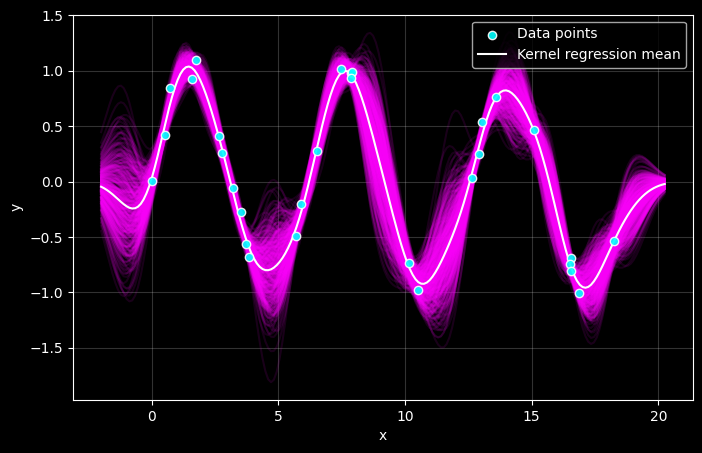

In [19]:
# Compute the inverse of full Hessian matrix
hessian = v_samples_train.T @ v_samples_train/ sigma_d**2 + np.eye(v_samples_train.shape[1]) / sigma_theta**2
# Ensure symmetry
hessian = (hessian + hessian.T) / 2
# Add a small identity matrix to ensure positive semi-definiteness
hessian += np.eye(hessian.shape[0]) * 1e-7
h_mat = np.linalg.inv(hessian)
print(f'hessian shape: {hessian.shape}')
print(f'hessian is positive semi-definite: {np.all(np.linalg.eigvals(hessian) > 0)}')

# Sample from the approximate posterior p(theta|D)
num_samples = 500
theta_samples = np.random.multivariate_normal(theta, h_mat, num_samples)
print(f'theta_samples shape: {theta_samples.shape}')
print(f'x_test_kernel shape: {v_samples_test.shape}')

# Visualize uncertainty
y_samples = v_samples_test @ theta_samples.T  # (n_x_test, n_theta_samples)
print(f'y_samples shape: {y_samples.shape}')

fig_3, ax_3 = plt.subplots(figsize=(8, 5))
ax_3.scatter(x, y, color='cyan', label='Data points', alpha=0.9, edgecolors='w',zorder=10)
for i in range(num_samples):
    ax_3.plot(x_test, y_samples.T[i], color='magenta', alpha=0.1)
ax_3.plot(x_test, y_test, color='white', label='Kernel regression mean')
ax_3.set_xlabel('x')
ax_3.set_ylabel('y')
ax_3.legend(loc='upper right')
ax_3.grid(True, alpha=0.2)
plt.show()

#### Bayesian marginalization with Monte Carlo

This section is exactly the same as before in linear model, except
* `predictive_mean = v_samples_test[i, :] @ theta_sample`, rather than `predictive_mean = a_sample * x_`
* a `correction step` about covariance (see notes)

In [20]:
# Posterior mean and variance for prediction (numerical)
posterior_mean_y = np.zeros(len(v_samples_test))
posterior_var_y = np.zeros(len(v_samples_test))

num_samples_predictive_per_theta = 5

for i, x_ in enumerate(v_samples_test):
    predictive_samples = []
    for theta_sample in theta_samples:
        predictive_mean = v_samples_test[i, :] @ theta_sample
        predictive_var = sigma_d**2
        individual_pred_dist = np.random.normal(predictive_mean, np.sqrt(predictive_var), num_samples_predictive_per_theta)
        predictive_samples.extend(individual_pred_dist)

    posterior_mean_y[i] = np.mean(predictive_samples)
    posterior_var_y[i] = np.var(predictive_samples)

k_star_star = rbf_kernel(x_test, x_test, sigma_k)

# Correction step
posterior_var_y = posterior_var_y - np.diag(v_samples_test@v_samples_test.T) + np.diag(k_star_star)

posterior_std_y = np.sqrt(posterior_var_y)

#### Bayesian marginalization (analytical, as reference for comparison with numerical)

In [21]:
use_formula = '2.12'

if use_formula == '2.12':
    # Compute posterior mean and covariance using kernel in original space, eq. 2.12, in Rasmussen and Williams's Gaussian process book
    H_mat = x_k + np.eye(x_k.shape[0]) * sigma_d**2

    H_mat = (H_mat + H_mat.T) / 2
    H_mat += np.eye(H_mat.shape[0]) * 1e-6 # for numerical stability
    H_mat_inv = np.linalg.inv(H_mat)

    analytical_mean_y = x_test_kernel @ H_mat_inv @ y
    cov_mat = rbf_kernel(x_test, x_test, sigma_k) - x_test_kernel @ H_mat_inv @ x_test_kernel.T

    analytical_std_y = np.sqrt((np.diagonal(cov_mat)))

elif use_formula == '2.11':
    # Compute covariance using virtual sample in feature space, eq. 2.11 in RW's GP book
    A_mat = v_samples_train.T @ v_samples_train / sigma_d**2 + np.eye(v_samples_train.shape[1]) / sigma_theta**2

    A_mat = (A_mat + A_mat.T) / 2
    A_mat += np.eye(A_mat.shape[0]) * 1e-6 # for numerical stability
    A_mat_inv = np.linalg.inv(A_mat)

    analytical_mean_y = 1/ sigma_d**2 * v_samples_test @ A_mat_inv @ v_samples_train.T @ y

    k_star_star = rbf_kernel(x_test, x_test, sigma_k)

    cov_mat_feature = v_samples_test @ A_mat_inv @ v_samples_test.T

    # Correction step
    cov_mat = cov_mat_feature - v_samples_test @ v_samples_test.T + k_star_star

    analytical_std_y = np.sqrt((np.diagonal(cov_mat)))

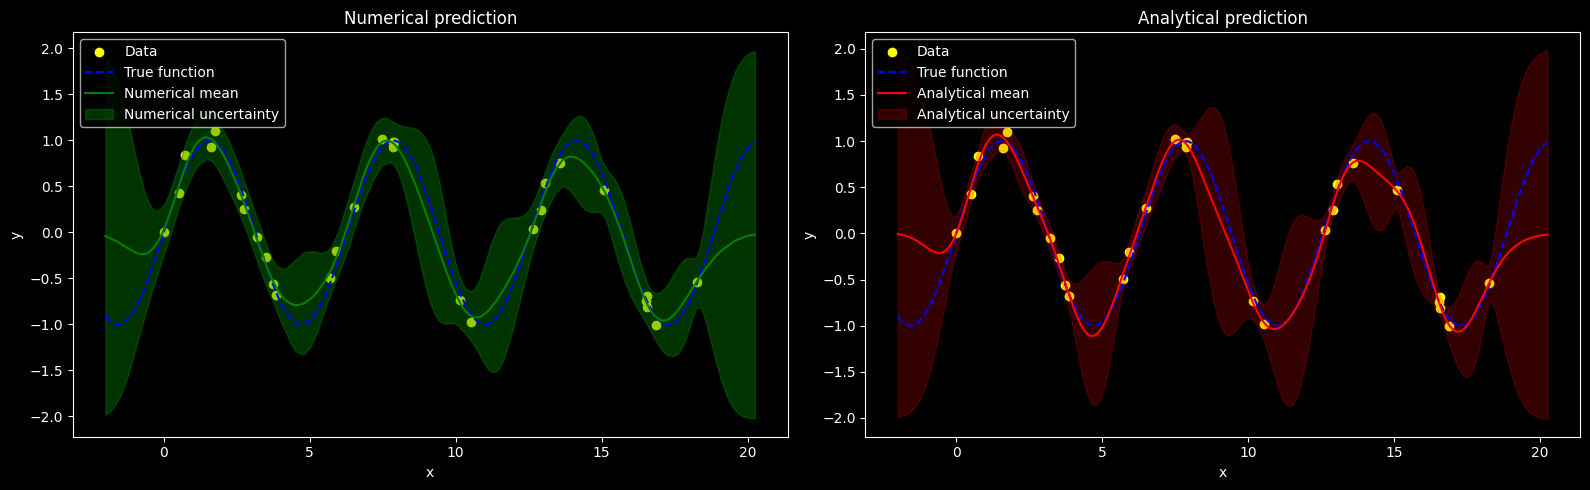

In [22]:
fig_4, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot numerical posterior mean and uncertainty
axes[0].scatter(x, y, label='Data', color='yellow')
axes[0].plot(x_test, np.sin(x_test), label='True function', color='blue', linestyle='--')
axes[0].plot(x_test, posterior_mean_y, label='Numerical mean', color='green')
axes[0].fill_between(x_test,
                     posterior_mean_y - 2 * posterior_std_y,
                     posterior_mean_y + 2 * posterior_std_y,
                     color='green', alpha=0.4, label='Numerical uncertainty')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Numerical prediction')
axes[0].legend(loc='upper left')

# Plot analytical posterior mean and uncertainty
axes[1].scatter(x, y, label='Data', color='yellow')
axes[1].plot(x_test, np.sin(x_test), label='True function', color='blue', linestyle='--')
axes[1].plot(x_test, analytical_mean_y, label='Analytical mean', color='red')
axes[1].fill_between(x_test,
                     analytical_mean_y - 2 * analytical_std_y,
                     analytical_mean_y + 2 * analytical_std_y,
                     color='red', alpha=0.2, label='Analytical uncertainty')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Analytical prediction')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()